Prepare

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))
min_class_size

6313

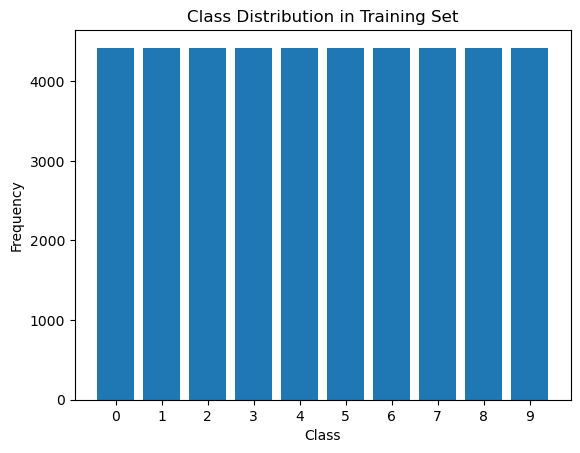

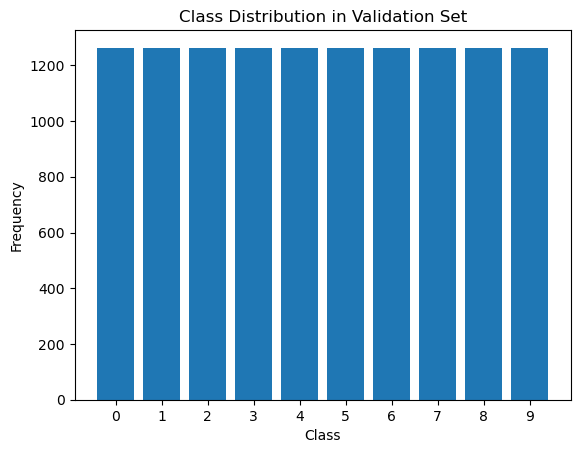

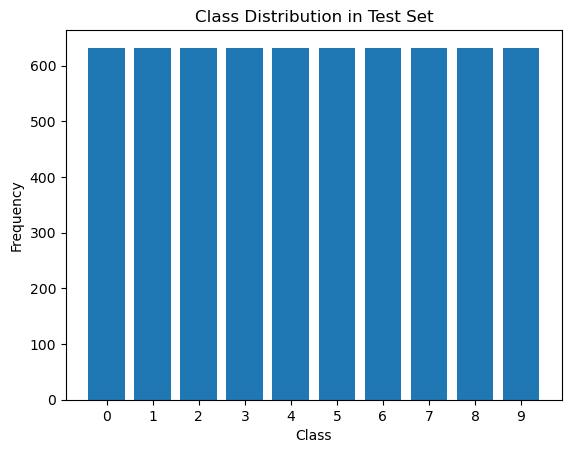

In [12]:
# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)
for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')

Prepare EMNIST to gauge generalisation

In [39]:
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
# emnist_labels = to_categorical(emnist_labels, 10)
# emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000,))

Shape of one-hot encoded labels: (10000, 10)


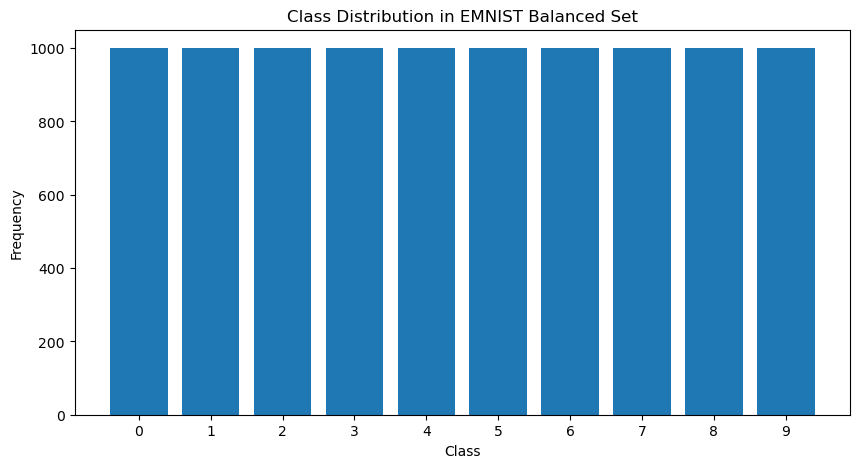

In [41]:
# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 1000
balanced_indices = []

for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

def plot_class_distribution(labels, dataset_name):
    class_counts = np.sum(labels, axis=0)  # This should result in a shape of (10,)
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Make sure emnist_y_balanced_one_hot is correctly shaped as (10000, 10)
print("Shape of one-hot encoded labels:", emnist_y_balanced_one_hot.shape)
plot_class_distribution(emnist_y_balanced_one_hot, 'EMNIST Balanced')

Train the model

In [44]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

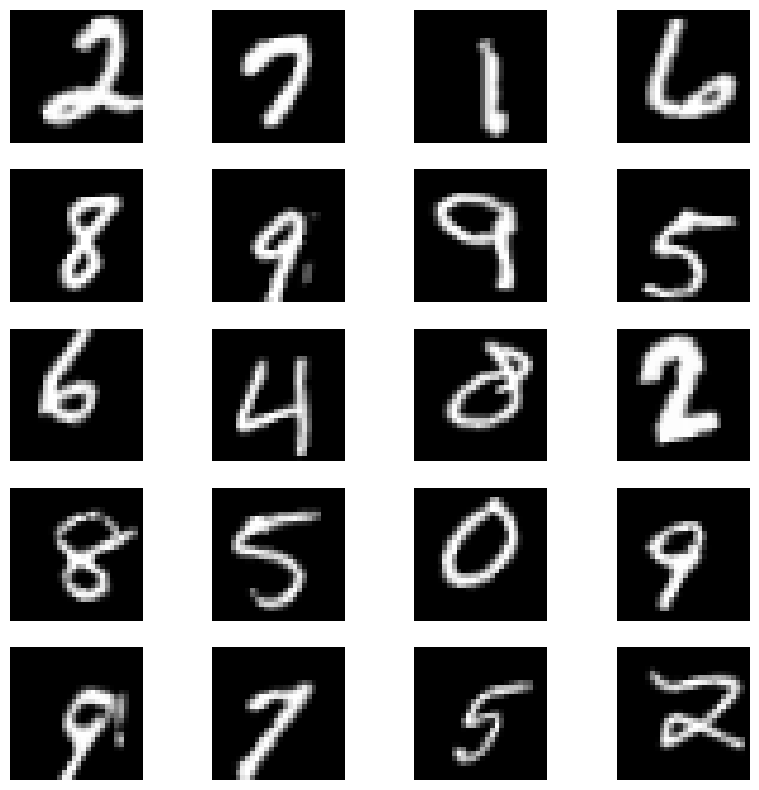

In [45]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Fit the data augmentation
datagen.fit(x_train_cnn)

# # Use the data generator to augment the training data
# cnn_model.fit(datagen.flow(x_train_cnn, y_train, batch_size=64), epochs=10, validation_data=(x_val_cnn, y_val))

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_cnn, y_train, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [46]:
# Define the CNN model
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=(3,  3), activation='relu', input_shape=(28,  28,  1)),
    MaxPooling2D(pool_size=(2,  2)),
    Conv2D(64, (3,  3), activation='relu'),
    MaxPooling2D(pool_size=(2,  2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use the data generator to augment the training data
cnn_history_1 = cnn_model_1.fit(datagen.flow(x_train_cnn, y_train, batch_size=64),
                            epochs=25,
                            validation_data=(x_val_cnn, y_val))

Epoch 1/25


2024-02-17 17:31:31.877085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 17:31:31.908565: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


691/691 [==============================] - 7s 9ms/step - loss: 1.8537 - accuracy: 0.3313 - val_loss: 0.8221 - val_accuracy: 0.7588
Epoch 2/25
691/691 [==============================] - 7s 9ms/step - loss: 1.2578 - accuracy: 0.5758 - val_loss: 0.5726 - val_accuracy: 0.8553
Epoch 3/25
691/691 [==============================] - 7s 10ms/step - loss: 1.0650 - accuracy: 0.6421 - val_loss: 0.4417 - val_accuracy: 0.8780
Epoch 4/25
691/691 [==============================] - 7s 10ms/step - loss: 0.8895 - accuracy: 0.7031 - val_loss: 0.3188 - val_accuracy: 0.9234
Epoch 5/25
691/691 [==============================] - 7s 10ms/step - loss: 0.7653 - accuracy: 0.7503 - val_loss: 0.2497 - val_accuracy: 0.9387
Epoch 6/25
691/691 [==============================] - 7s 9ms/step - loss: 0.6767 - accuracy: 0.7789 - val_loss: 0.2139 - val_accuracy: 0.9451
Epoch 7/25
691/691 [==============================] - 7s 10ms/step - loss: 0.6193 - accuracy: 0.7999 - val_loss: 0.1783 - val_accuracy: 0.9537
Epoch 8/25
69

Evaluate on MNIST

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

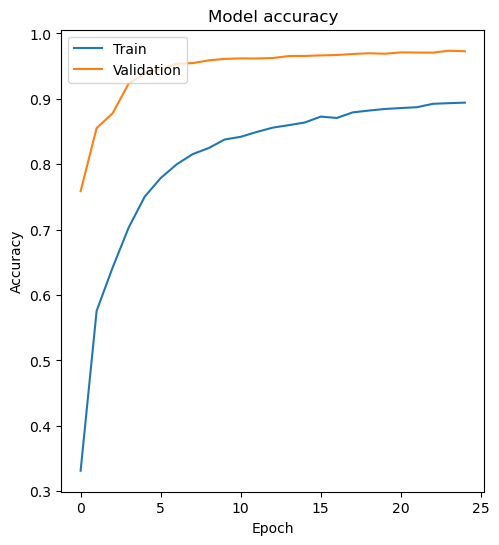

In [48]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_1.history['accuracy'])
plt.plot(cnn_history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [54]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model_1.predict(x_val_cnn)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

395/395 [==============================] - 1s 2ms/step
Precision:  0.972881410095359
Recall:  0.9728338349437669
F1 Score:  0.9728028735823184
Confusion Matrix:
 [[1246    0    0    1    0    1    8    2    3    1]
 [   1 1245    8    3    2    0    0    0    3    0]
 [   1    3 1232    7    3    1    0    6    9    1]
 [   3    0   13 1222    0   11    0    5    5    3]
 [   1    0    2    0 1234    0    5    2    0   19]
 [   1    1    1   10    1 1235    8    0    1    5]
 [   4    1    0    0    1    5 1250    0    2    0]
 [   2    3   15    8    1    1    0 1224    2    7]
 [   3    0    3    8    8   21   17    4 1193    6]
 [   7    1    0   13   19    3    1   15    1 1202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1262
           1       0.99      0.99      0.99      1262
           2       0.97      0.98      0.97      1263
           3       0.96      0.97      0.96      1262
           4

Evaluate on EMNIST

In [59]:
# Evaluate on MNIST Validation Set
y_emnist_pred_probs = cnn_model_1.predict(emnist_x_balanced)
emnist_y_pred = np.argmax(y_emnist_pred_probs, axis=1)
emnist_y_true = emnist_y_balanced

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
recall = recall_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
f1 = f1_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
conf_mat = confusion_matrix(emnist_y_true, emnist_y_pred)
report = classification_report(emnist_y_true, emnist_y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

313/313 [==============================] - 1s 2ms/step
Precision:  0.9608986655955285
Recall:  0.9605
F1 Score:  0.9602142306032729
Confusion Matrix:
 [[991   0   3   0   0   1   3   0   1   1]
 [  0 983   5   0   0   0   4   3   5   0]
 [  6   1 966   8   4   0   1   0  14   0]
 [  1   0  10 974   0   9   0   1   4   1]
 [  2   3   2   0 945   0  13   4   7  24]
 [  8   0   0   5   0 981   3   0   3   0]
 [  9   0   1   0   1   2 987   0   0   0]
 [  0   3  15   6   1   0   0 966   7   2]
 [  9   2   3  11   0  11   3   2 958   1]
 [  2   0   1  14  17   6   2  63  41 854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.99      0.98      0.99      1000
           2       0.96      0.97      0.96      1000
           3       0.96      0.97      0.97      1000
           4       0.98      0.94      0.96      1000
           5       0.97      0.98      0.98      1000
           6   

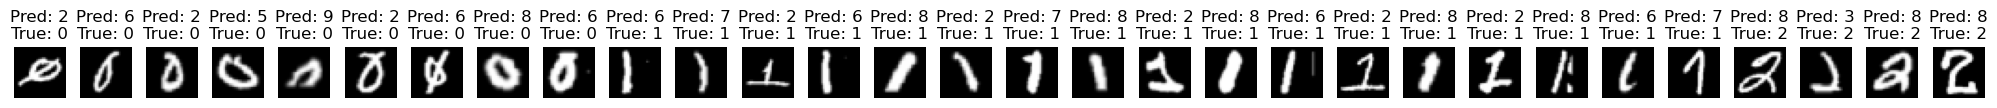

In [62]:
# Identify misclassified images
misclassified_indices = np.where(emnist_y_pred != emnist_y_true)[0]
misclassified_images = emnist_x_balanced[misclassified_indices]
misclassified_predictions = emnist_y_pred[misclassified_indices]
true_labels_misclassified = emnist_y_true[misclassified_indices]

# Plot a sample of misclassified images
num_images_to_show = 30
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        ax.imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {misclassified_predictions[i]}\nTrue: {true_labels_misclassified[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()